# Saliancy Maps on the HSCNN+ Model
### It is a model that takes an RGB image and outputs a 31 bands spectral image

In [1]:
import os
import cv2
import numpy as np
import torch
from torchvision import models
from IPython.display import Image
import torch.nn as nn
from torch.nn import ReLU
import matplotlib.pyplot as plt
from PIL import Image as PilImage
import torchvision.transforms as T

d:\Norway2.0\AAA\AAA\envf\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch.backends.cudnn as cudnn
from architecture import *
from utils import AverageMeter, save_matv73, Loss_MRAE, Loss_RMSE, Loss_PSNR, Loss_MRAE2, Loss_SAM
from hsi_dataset import TrainDataset, ValidDataset, ValidDataset_2, ValidDataset_3, ValidDataset_4
from torch.utils.data import DataLoader

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [19]:
os.environ["CUDA_DEVICE_ORDER"] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
outf = './exp/hscnn_plus/'
if not os.path.exists(outf):
    os.makedirs(outf)
data_root='../dataset_ref2/A/'
width = 20
# load dataset
val_data = ValidDataset_3(data_root=data_root, bgr2rgb=True)
val_loader = DataLoader(dataset=val_data, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

len(hyper_valid) of ntire2022 dataset:8
len(bgr_valid) of ntire2022 dataset:8
Ntire2022 scene 0 is loaded.
Ntire2022 scene 1 is loaded.
Ntire2022 scene 2 is loaded.
Ntire2022 scene 3 is loaded.
Ntire2022 scene 4 is loaded.
Ntire2022 scene 5 is loaded.
Ntire2022 scene 6 is loaded.
Ntire2022 scene 7 is loaded.


In [20]:
method = 'hscnn_plus'
# loss function
loss_sam_arr = []
big_arr = []
criterion_mrae = Loss_MRAE2()
criterion_rmse = Loss_RMSE()
criterion_psnr = Loss_PSNR()
criterion_sam  = Loss_SAM()
if torch.cuda.is_available():
    criterion_mrae.cuda()
    criterion_rmse.cuda()

# Validate
with open(f'{data_root}/split_txt/valid_list.txt', 'r') as fin:
    hyper_list = [line.replace('\n', '.mat') for line in fin]
with open(f'{data_root}/split_txt/valid_list.txt', 'r') as fin:
    hyper_list_rgb = [line.replace('\n', '.png') for line in fin]
hyper_list.sort()
hyper_list_rgb.sort()
var_name = 'cube'
def validate(val_loader, model):
    model.eval()
    losses_mrae = AverageMeter()
    losses_rmse = AverageMeter()
    losses_psnr = AverageMeter()
    losses_sam = AverageMeter()
    for i, (input, target) in enumerate(val_loader):
        input = input#.cuda()
        target = target#.cuda()
        with torch.no_grad():
            # compute output
            if method=='awan':   # To avoid out of memory, we crop the center region as input for AWAN.
                output = model(input[:, :, 118:-118, 118:-118])
                loss_mrae = criterion_mrae(output[:, :, 10:-10, 10:-10], target[:, :, 128:-128, 128:-128])
                loss_rmse = criterion_rmse(output[:, :, 10:-10, 10:-10], target[:, :, 128:-128, 128:-128])
                loss_psnr = criterion_psnr(output[:, :, 10:-10, 10:-10], target[:, :, 128:-128, 128:-128])
            else:
                output = model(input)
                loss_mrae, map_mrae = criterion_mrae(output, target)
                loss_rmse = criterion_rmse(output, target)
                loss_psnr = criterion_psnr(output, target)
                loss_sam, map_sam = criterion_sam(output, target)
        # record loss
        losses_mrae.update(loss_mrae.data, i)
        losses_rmse.update(loss_rmse.data, i)
        losses_psnr.update(loss_psnr.data, i)
        losses_sam.update(loss_sam.data, i)

        loss_sam_arr.append(loss_sam.data)

        # # plt.imshow(map_mrae, cmap='gray', vmin=0, vmax=1)
        # # plt.show()

        img_name = hyper_list_rgb[i]
        transform=T.ToPILImage()
        # img = transform(map_mrae)
        img = transform(map_sam)
        # img.save('../mrae_maps/'+ method + '/' + img_name)
        img.save('../sam_maps/'+ method + '/' + img_name)
        # img.save('../sam_maps/'+ method + '/' + 'test' + str(i) + '.png' )


        # result = output.cpu().numpy() * 1.0
        # result = np.transpose(np.squeeze(result), [1, 2, 0])
        # result = np.minimum(result, 1.0)
        # result = np.maximum(result, 0)
        # mat_name = hyper_list[i]
        # mat_dir = os.path.join(outf, mat_name)
        # save_matv73(mat_dir, var_name, result)
        # plt.imshow(map_sam)
        # indicator = val_data.__getindicator__(i)
        # x, y = indicator[2][0], indicator[2][1]
        # pixel_error = map_sam[x, y]
        # value = [pixel_error, indicator]
        # print(value)
        # big_arr.append(value)

    return losses_mrae.avg, losses_rmse.avg, losses_psnr.avg, losses_sam.avg, losses_mrae, losses_rmse, losses_psnr, losses_sam

In [21]:
cudnn.benchmark = True
pretrained_model_path = './model_zoo/hscnn_plus.pth'
method = 'hscnn_plus'
model = model_generator(method, pretrained_model_path)#.cuda()

load model from ./model_zoo/hscnn_plus.pth


In [ ]:
# Box tests v1
mrae_avg, rmse_avg, psnr_avg, sam_avg, losses_mrae, losses_rmse, losses_psnr, losses_sam = validate(val_loader, model)
print(f'method:{method}, mrae:{mrae_avg}, rmse:{rmse_avg}, psnr:{psnr_avg}, sam:{sam_avg}')

In [7]:
import pickle
with open(f'big_arr_{method}_painted', "wb") as fp:
    pickle.dump(big_arr, fp)

In [ ]:
with open('big_arr_{method}_black', "rb") as fp:
    big_arr = pickle.load(fp)

In [22]:
# A light images v3
mrae_avg, rmse_avg, psnr_avg, sam_avg, losses_mrae, losses_rmse, losses_psnr, losses_sam = validate(val_loader, model)
print(f'method:{method}, mrae:{mrae_avg}, rmse:{rmse_avg}, psnr:{psnr_avg}, sam:{sam_avg}')

method:hscnn_plus, mrae:inf, rmse:0.19030387699604034, psnr:14.955851554870605, sam:0.3003665804862976


In [18]:
# D65 light images v3
mrae_avg, rmse_avg, psnr_avg, sam_avg, losses_mrae, losses_rmse, losses_psnr, losses_sam = validate(val_loader, model)
print(f'method:{method}, mrae:{mrae_avg}, rmse:{rmse_avg}, psnr:{psnr_avg}, sam:{sam_avg}')

method:hscnn_plus, mrae:inf, rmse:0.162611722946167, psnr:16.401012420654297, sam:0.30692899227142334


In [6]:
# line tests v2
mrae_avg, rmse_avg, psnr_avg, sam_avg, losses_mrae, losses_rmse, losses_psnr, losses_sam = validate(val_loader, model)
print(f'method:{method}, mrae:{mrae_avg}, rmse:{rmse_avg}, psnr:{psnr_avg}, sam:{sam_avg}')

torch.Size([1, 31, 224, 224])
torch.Size([1, 31, 224, 224])
torch.Size([1, 31, 224, 224])
torch.Size([1, 31, 224, 224])
torch.Size([1, 31, 224, 224])
torch.Size([1, 31, 224, 224])
torch.Size([1, 31, 224, 224])
torch.Size([1, 31, 224, 224])
torch.Size([1, 31, 224, 224])
torch.Size([1, 31, 224, 224])
torch.Size([1, 31, 224, 224])
torch.Size([1, 31, 224, 224])
method:hscnn_plus, mrae:3.866528272628784, rmse:0.3225304186344147, psnr:9.966889381408691, sam:0.5436248183250427


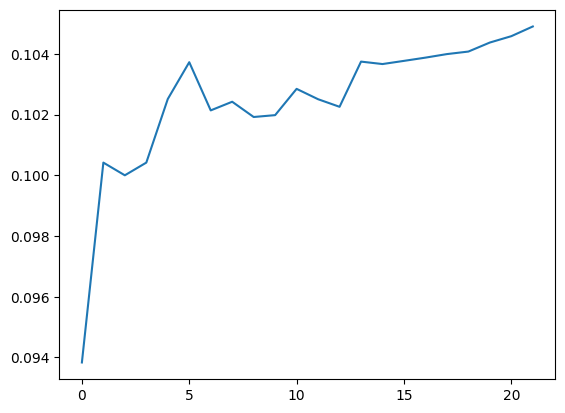

In [15]:
loss_sam_arr[2] = 0.1
plt.plot(loss_sam_arr)

In [6]:
mrae_avg, rmse_avg, psnr_avg, sam_avg, losses_mrae, losses_rmse, losses_psnr, losses_sam = validate(val_loader, model)
print(f'method:{method}, mrae:{mrae_avg}, rmse:{rmse_avg}, psnr:{psnr_avg}, sam:{sam_avg}')

method:hscnn_plus, mrae:inf, rmse:0.0670791044831276, psnr:24.44135093688965, sam:0.10427703708410263


Guided Back Propogation part

In [7]:
# path = '../../testSet/' # path to the test input images
# path = '../../input_images/' # path to the test input images
path = '../../color_set/' # path to the test input images

In [8]:
from misc_functions import (get_example_params,
                            convert_to_grayscale,
                            save_gradient_images,
                            get_positive_negative_saliency,
                            preprocess_image)
from architecture.MST_Plus_Plus import GELU

class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        # Put model in evaluation mode
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
        # Register hook to the first layer
        # first_layer = list(self.model.features._modules.items())[0][1]
        first_layer = self.model.ddfn.conv_up1
        # print(first_layer)
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        """
            Updates relu activation functions so that
                1- stores output in forward pass
                2- imputes zero for gradient values that are less than zero
        """
        def relu_backward_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, change it to zero
            """
            # Get last forward output
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            """
            Store results of forward pass
            """
            self.forward_relu_outputs.append(ten_out)

        # Loop through layers, hook up ReLUs
        # for pos, module in self.model.features._modules.items():
        for module in self.model.modules():
            if isinstance(module, nn.ReLU):
                # print(module)
                module.register_backward_hook(relu_backward_hook_function)
                module.register_forward_hook(relu_forward_hook_function)

    def generate_gradients(self, input_image, target_pixelx, target_pixely, fullImage=False):
        # Forward pass
        model_output = self.model(input_image)
        # print('model output', model_output.size())
        # Zero gradients
        self.model.zero_grad()
        # Target for backprop
        output_tensor = torch.FloatTensor(model_output.size()).zero_()
        # print('output_tensor', output_tensor.size())
        if fullImage:
            output_tensor[0, :, :, :] = 1
        else:
            output_tensor[0, :, target_pixelx, target_pixely] = 1  
        # print('output_tensor', output_tensor.size())
        # Backward pass
        model_output.backward(gradient=output_tensor)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr


In [9]:
concatenated_grays = np.zeros((224, 224))
for (root, dirs, file) in os.walk(path):
    for f in file:
        x, y = 200, 100
        print(path + f)
        target_example = 0
        img_path = path + f
        target_class = 0
        file_name_to_export = img_path[img_path.rfind('/')+1:img_path.rfind('.')]
        # Read image
        original_image = PilImage.open(img_path).convert('RGB')
        # Process image
        prep_img = preprocess_image(original_image)
        # Guided backprop
        GBP = GuidedBackprop(model)
        # Get gradients
        guided_grads = GBP.generate_gradients(prep_img, x, y, fullImage=True)
        # Save colored gradients
        save_gradient_images(guided_grads, file_name_to_export + '_Guided_BP_color')
        # Convert to grayscale
        grayscale_guided_grads = convert_to_grayscale(guided_grads)
        # Save grayscale gradients
        save_gradient_images(grayscale_guided_grads, file_name_to_export + '_Guided_BP_gray')
        # Positive and negative saliency maps
        pos_sal, neg_sal = get_positive_negative_saliency(guided_grads)
        save_gradient_images(pos_sal, file_name_to_export + '_pos_sal')
        save_gradient_images(neg_sal, file_name_to_export + '_neg_sal')

        concatenated_grays = np.dstack((concatenated_grays, grayscale_guided_grads.squeeze()))

        print(file_name_to_export)
        print('Guided backprop completed')

../../color_set/A.jpg
A
Guided backprop completed
../../color_set/A2.jpg
A2
Guided backprop completed
../../color_set/D65.jpg
D65
Guided backprop completed
../../color_set/D652.jpg
D652
Guided backprop completed
../../color_set/m1.jpg
m1
Guided backprop completed
../../color_set/m2.jpg
m2
Guided backprop completed
../../color_set/w5.jpg
w5
Guided backprop completed


In [ ]:
for module in model.modules():
    if isinstance(module, nn.ReLU):
        print(module)

This block is to run on only one image 

In [9]:
print([module for module in model.modules() if not isinstance(module, nn.Sequential)])

[HSCNN_Plus(
  (ddfn): ddfn(
    (conv_up1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv_up2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (conv_down1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv_down2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (dfus_blocks): Sequential(
      (0): dfus_block(
        (conv1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (conv_up1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv_up2): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (conv_down1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv_down2): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (conv_fution): Conv2d(96, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
    

In [ ]:
target_example = 0  # Snake
(original_image, prep_img, target_class, file_name_to_export, _) = get_example_params(target_example)
x, y = 200, 100
# Guided backprop
GBP = GuidedBackprop(model.module)
# Get gradients
guided_grads = GBP.generate_gradients(prep_img, x, y)
# Save colored gradients
save_gradient_images(guided_grads, file_name_to_export + '_Guided_BP_color')
# Convert to grayscale
grayscale_guided_grads = convert_to_grayscale(guided_grads)
# Save grayscale gradients
save_gradient_images(grayscale_guided_grads, file_name_to_export + '_Guided_BP_gray')
# Positive and negative saliency maps
pos_sal, neg_sal = get_positive_negative_saliency(guided_grads)
save_gradient_images(pos_sal, file_name_to_export + '_pos_sal')
save_gradient_images(neg_sal, file_name_to_export + '_neg_sal')
print(file_name_to_export)
print('Guided backprop completed')

Pixel 200, 100 Large dataset average pooled representation

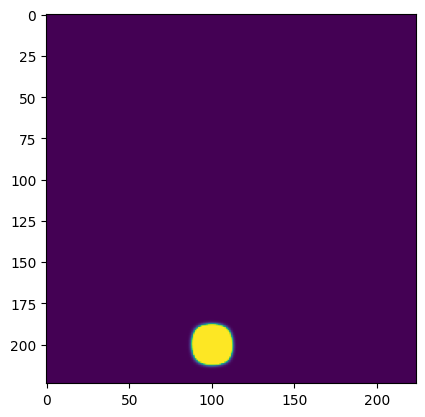

627


In [20]:
average_grays = np.mean(concatenated_grays[:, :, 1:], axis=2)

%matplotlib inline
thresholded = (average_grays > 0.1) * average_grays
plt.imshow(average_grays)
plt.show()
# plt.imshow(thresholded)
# plt.show()
area = np.count_nonzero(thresholded)
print(area)

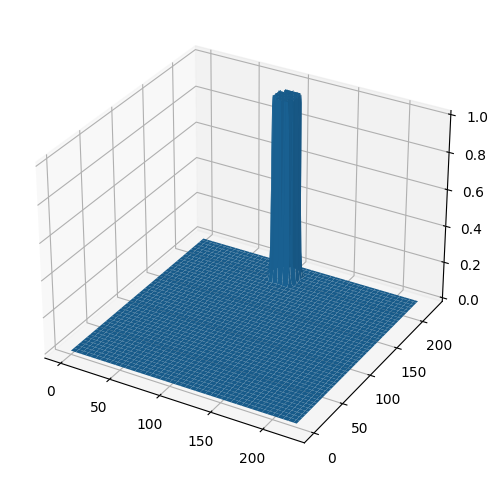

In [21]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
#if using a Jupyter notebook, include:
%matplotlib inline
x = np.arange(0, 224, 1)
y = np.arange(0, 224, 1)
X,Y = np.meshgrid(x,y)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, average_grays.squeeze())
plt.show()

Pixel 100, 100 Large dataset average pooled representation

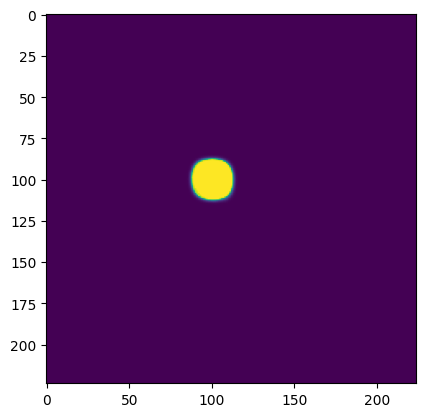

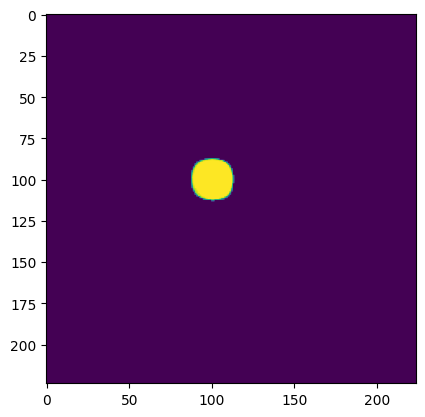

557


In [23]:
average_grays = np.mean(concatenated_grays[:, :, 1:], axis=2)

%matplotlib inline
thresholded = (average_grays > 0.4) * average_grays
plt.imshow(average_grays)
plt.show()
plt.imshow(thresholded)
plt.show()
area = np.count_nonzero(thresholded)
print(area)

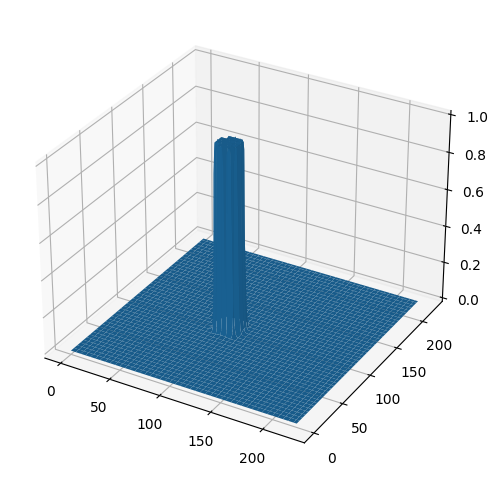

In [24]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
#if using a Jupyter notebook, include:
%matplotlib inline
x = np.arange(0, 224, 1)
y = np.arange(0, 224, 1)
X,Y = np.meshgrid(x,y)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, average_grays.squeeze())
plt.show()

For Snake dataset mid pixel 200, 100

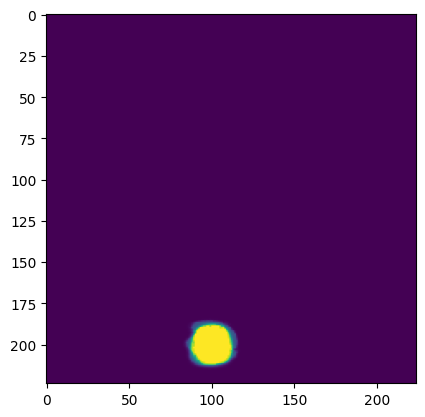

710


In [11]:
average_grays = np.mean(concatenated_grays[:, :, 1:], axis=2)

%matplotlib inline
thresholded = (average_grays > 0.1) * average_grays
plt.imshow(average_grays)
plt.show()
# plt.imshow(thresholded)
# plt.show()
area = np.count_nonzero(thresholded)
print(area)

For Snake dataset edge pixel 223, 100

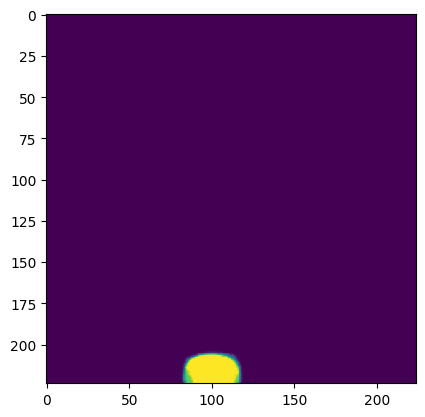

592


In [9]:
average_grays = np.mean(concatenated_grays[:, :, 1:], axis=2)

%matplotlib inline
thresholded = (average_grays > 0.1) * average_grays
plt.imshow(average_grays)
plt.show()
# plt.imshow(thresholded)
# plt.show()
area = np.count_nonzero(thresholded)
print(area)